In [153]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 

import numpy as np
import matplotlib.pyplot as plt
from fisher_rao_amplitude import fm, d
from distance_utils import *
from mrf import rf, rf_weights
import skfda
from skfda.misc.operators import SRSF
import matplotlib.pyplot as plt
from ipywidgets import *
from tqdm import tqdm
from skfda._utils import invert_warping

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


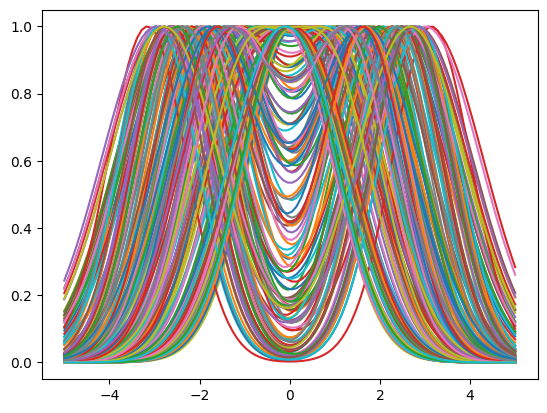

In [6]:
# what would be a good data generating process for amplitude distance?
# Variable Selection in Function-on-Scalar Regression
grid = np.linspace(-5, 5, 100)

def gen_data(N, eps=0.1, d=1):
    x = np.random.rand(N*d).reshape((N,d))
#     beta = np.random.normal(0, 10, size=d)
#     t = X #1 / (1 + np.exp(X.dot(beta)))
    
    def m(x):
        mu_1 = x*3 - (1-x)*3 + eps*np.random.randn()
        mu_2 = -mu_1 + eps*np.random.randn()
        sig = 3 / (x + 1)
        y = np.exp(-(grid - mu_1)**2 / sig) + np.exp(-(grid - mu_2)**2 / sig)
        return y / np.max(y)

    y = np.zeros((N, grid.shape[0]))
    for i in range(N): y[i,:] = m(x[i,:])

    return x, skfda.FDataGrid(y, grid)

N=200; p=1; eps=0.1
x_train, y_train = gen_data(N, eps, p)
x_test, y_test = gen_data(100, eps, p)


y_train.plot();

In [7]:
# todo: this is probably not required and vectorizing should be faster
# but anyways I need to parallelize

def D_mat_sq(d, y):
    N = y.shape[0]
    D = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            D[i, j] = d(y[i], y[j])**2
    return D + D.T

D = D_mat_sq(d, y_train)
forest = rf(500, x_train, D, 150)

In [171]:
from joblib import Parallel, delayed

def D_mat_sq_par(d, y):
    N = y.shape[0]
    def calc(i, ally): 
        D = np.zeros(N)
        for j in range(i+1,N):
            D[j] = d(y[i], y[j])**2
        return D
    
    D = Parallel(n_jobs=6, verbose=1)(delayed(calc)(i,y) for i in range(N))
    D = np.r_[D]
    return D + D.T

D = D_mat_sq_par(d, y_train)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   23.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 200 out of 200 | elapsed:  1.1min finished


array([[0.        , 0.00329183, 0.13382844, ..., 0.21515342, 0.06726971,
        0.00680288],
       [0.00329183, 0.        , 0.15175569, ..., 0.23760967, 0.09318521,
        0.01883119],
       [0.13382844, 0.15175569, 0.        , ..., 0.04800406, 0.04843801,
        0.10912983],
       ...,
       [0.21515342, 0.23760967, 0.04800406, ..., 0.        , 0.12603416,
        0.18917943],
       [0.06726971, 0.09318521, 0.04843801, ..., 0.12603416, 0.        ,
        0.04833392],
       [0.00680288, 0.01883119, 0.10912983, ..., 0.18917943, 0.04833392,
        0.        ]])

In [145]:
y_preds_data = np.zeros((x_test.shape[0], grid.shape[0]))
errs = np.zeros(x_test.shape[0])
ess = np.zeros(x_test.shape[0])

for i in tqdm(range(x_test.shape[0])):
    ws = rf_weights(forest, x_test[i,:])
    ess[i] = np.sum(ws)**2 / np.sum(np.power(ws,2))
    y_pred = fm(y_train, ws)
    y_preds_data[i,:] = y_pred.data_matrix[0,...,0]
    
y_preds = y_test.copy(data_matrix=y_preds_data)

for i in tqdm(range(x_test.shape[0])):
    errs[i] = d(y_preds[i], y_test[i])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.54it/s]


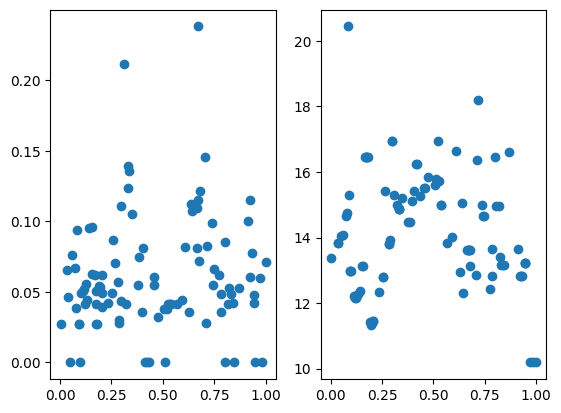

In [173]:
%matplotlib inline
plt.subplot(1,2,1)
plt.scatter(x_test, errs)
plt.subplot(1,2,2)
plt.scatter(x_test, ess)